<a href="https://colab.research.google.com/github/Haffizuddin7899/-Capstone-Project--Fungal_Disease_Detection_In_Plants_Using_Leaf_Images-/blob/main/Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Mount Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Define data directory path
data_dir = '/content/gdrive/MyDrive/Capstone Project/DATA/Color'

Mounted at /content/gdrive


# Step 2: Load Data And Apply Preprocessing And Augmentation

In [ ]:
# import ImageDataGenerator from tenserflow.keras.preprocesing.image for Data Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd


In [ ]:
# define Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of the data will be used for validation
)

In [ ]:
# Load  data
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # VGG16 input size
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 22244 images belonging to 22 classes.


In [ ]:
# Load training data
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'  # specify this is for training data
)


Found 17802 images belonging to 22 classes.


In [ ]:
# Load Validation Data
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42,
    subset='validation'  # specify this is for validation data
)

Found 4442 images belonging to 22 classes.


In [ ]:
# import necessary Libraries for Manual Data Splitting
import os
import shutil

In [ ]:
# Define new data directory test

split_dir = '/content/gdrive/MyDrive/Project/data_split'
os.makedirs(split_dir + 'test', exist_ok=True)

test_data_dir = os.path.join(split_dir, 'test')

In [ ]:
# Data augmentation and preprocessing for test data
test_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0, 1] for test data
)

# Load and augment test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for test data
)

Found 2218 images belonging to 22 classes.


# Step 3: Exploratory Data Analysis (EDA)

In [ ]:

# Data normalization and class weighting
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
# Calculate class weights to handle class imbalance manually
unique_classes, class_counts = np.unique(train_generator.classes, return_counts=True)
class_weights = len(train_generator.classes) / (len(unique_classes) * class_counts)

# Normalize class weights
class_weights = class_weights / np.sum(class_weights)



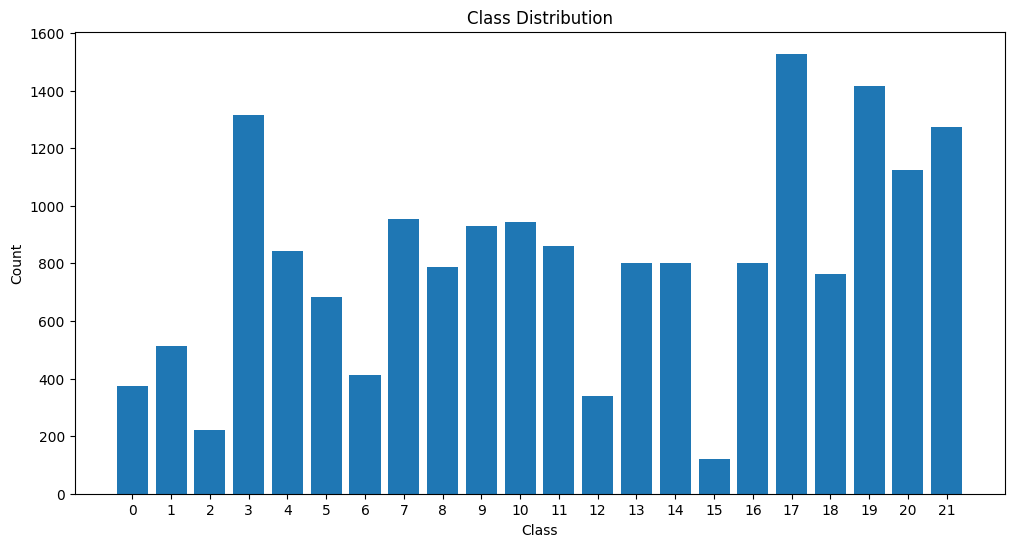

In [ ]:
import matplotlib.pyplot as plt


# EDA - Visualize class distribution
class_distribution = pd.Series(train_generator.classes).value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(class_distribution.index.astype(str), class_distribution)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


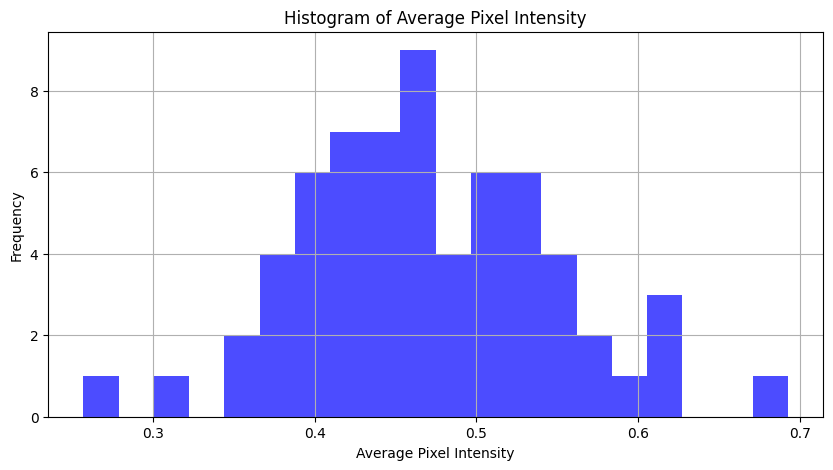

In [ ]:

# Get a batch of images from your generator for EDA
eda_batch = next(train_generator)  # You can adjust the batch size if needed

# Extract the images and their labels
eda_images, eda_labels = eda_batch

# Calculate the average pixel intensity for each image
average_pixel_intensity = np.mean(eda_images, axis=(1, 2, 3))  # This averages over all pixels for each image

# Create a histogram to visualize the average pixel intensity
plt.figure(figsize=(10, 5))
plt.hist(average_pixel_intensity, bins=20, color='blue', alpha=0.7)
plt.xlabel('Average Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Average Pixel Intensity')
plt.grid(True)
plt.show()


# Step 4: Load VGG16 pre-trained model


In [ ]:
# import necessary Libraries to Load VGG16 pre-trained model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [ ]:
# Load the VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Create a new model with custom top layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(22, activation='softmax')
])

In [ ]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 22)                11286     
                                                                 
Total params: 27571542 (105.18 MB)
Trainable params: 12856854 (49.05 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


# Step 5: Train the model

In [ ]:
# import laibary for TensorBoard Callback
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
# Define TensorBoard callback
tensorboard = TensorBoard(log_dir='./logs')

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# Define ModelCheckpoint callback
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/Capstone Project/best_model.h5',
                             save_best_only=True,
                             monitor='val_accuracy',
                             mode='max',
                             verbose=1)


In [ ]:
# Train the model using the generators
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[tensorboard, checkpoint]
)

Epoch 1/10
279/279 [==============================] - ETA: 0s - loss: 1.7859 - accuracy: 0.4739 
Epoch 1: val_accuracy improved from -inf to 0.75777, saving model to /content/gdrive/MyDrive/Capstone Project/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


279/279 [==============================] - 10539s 38s/step - loss: 1.7859 - accuracy: 0.4739 - val_loss: 0.7602 - val_accuracy: 0.7578
Epoch 2/10
279/279 [==============================] - ETA: 0s - loss: 1.0391 - accuracy: 0.6496
Epoch 2: val_accuracy improved from 0.75777 to 0.81270, saving model to /content/gdrive/MyDrive/Capstone Project/best_model.h5
279/279 [==============================] - 401s 1s/step - loss: 1.0391 - accuracy: 0.6496 - val_loss: 0.5681 - val_accuracy: 0.8127
Epoch 3/10
279/279 [==============================] - ETA: 0s - loss: 0.9022 - accuracy: 0.6864
Epoch 3: val_accuracy improved from 0.81270 to 0.83341, saving model to /content/gdrive/MyDrive/Capstone Project/best_model.h5
279/279 [==============================] - 399s 1s/step - loss: 0.9022 - accuracy: 0.6864 - val_loss: 0.5088 - val_accuracy: 0.8334
Epoch 4/10
279/279 [==============================] - ETA: 0s - loss: 0.8493 - accuracy: 0.7079
Epoch 4: val_accuracy improved from 0.83341 to 0.84782, sav

In [ ]:
# Save the model in h5 format
model.save('/content/gdrive/MyDrive/Capstone Project/model(ef=10).h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Step 6: Model Evaluation

In [ ]:
# import necessary Libraries for Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


139/139 [==============================] - 21s 153ms/step - loss: 0.2947 - accuracy: 0.8976
Test accuracy: 89.76%


In [ ]:
# Generate predictions
predictions = model.predict(test_generator)  # Use test_generator here
predicted_labels = np.argmax(predictions, axis=1)


139/139 [==============================] - 18s 129ms/step


In [ ]:
# True labels
true_labels = test_generator.labels  # Use test_generator.labels here

## 1. Precision  2. Recall  3. F1-Score

In [ ]:
# Classification report
class_names = list(train_generator.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.94      0.72      0.82        93
                                 Apple___Black_rot       0.83      1.00      0.91       128
                          Apple___Cedar_apple_rust       0.96      0.78      0.86        55
                                   Apple___healthy       0.94      0.97      0.96       329
          Cherry_(including_sour)___Powdery_mildew       0.98      0.98      0.98       210
                 Cherry_(including_sour)___healthy       1.00      0.99      0.99       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.85      0.56      0.67       102
                       Corn_(maize)___Common_rust_       0.95      1.00      0.97       238
               Corn_(maize)___Northern_Leaf_Blight       0.82      0.91      0.86       197
                            Corn_(maize)___healthy       0.99      0.99      0.

# Confusion Matrix

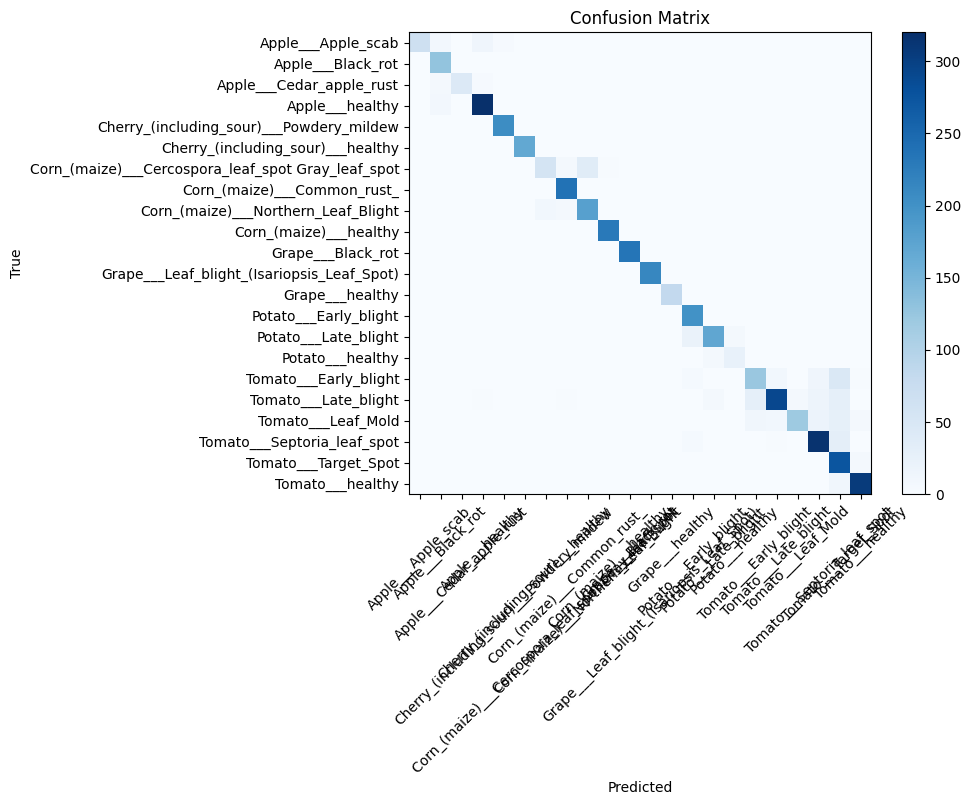

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Start TensorBoard in Colab
%load_ext tensorboard
%tensorboard --logdir ./logs


<IPython.core.display.Javascript object>

#Training and Validation Accuracy And Loss Curves

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy', color='blue')
plt.plot(validation_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss', color='blue')
plt.plot(validation_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Precision-Recall Curve

In [ ]:
# Assuming you have access to the data generator, you can get class names from there
class_names = list(train_generator.class_indices.keys())

# Get precision and recall for each class
for class_idx in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(
        (true_labels == class_idx).astype(int),
        predicted_probs[:, class_idx]
    )
    precision_list.append(precision)
    recall_list.append(recall)


139/139 [==============================] - 18s 130ms/step


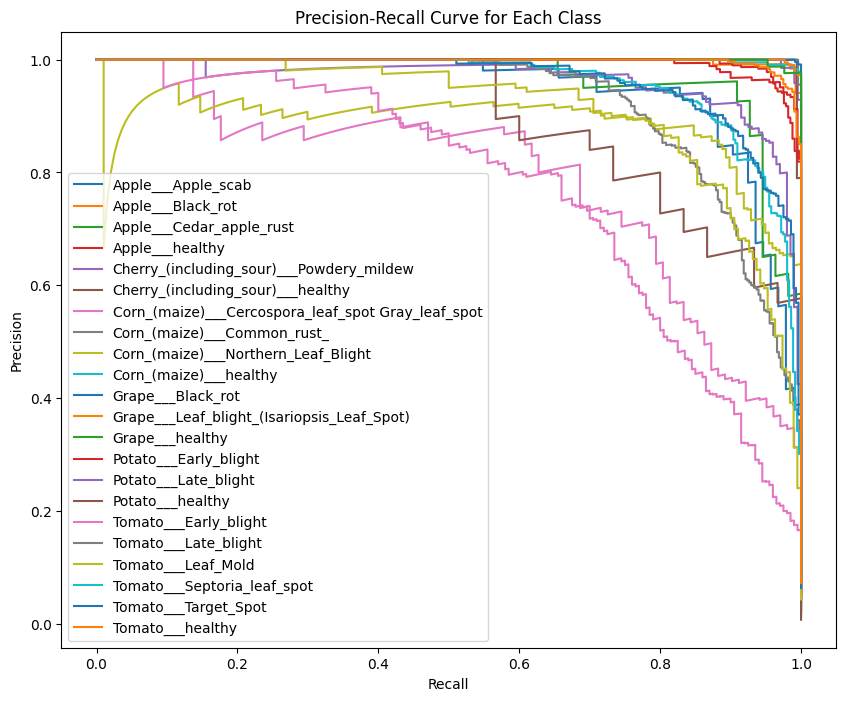

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Load the saved model
saved_model_path = '/content/gdrive/MyDrive/Capstone Project/model(VGG16-20).h5'  # Update the path accordingly
loaded_model = load_model(saved_model_path)

# Get the true labels and predicted probabilities for each class
true_labels = test_generator.labels
predicted_probs = loaded_model.predict(test_generator)

# Initialize lists to store precision and recall values for each class
precision_list = []
recall_list = []

# Get precision and recall for each class
for class_idx in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(
        (true_labels == class_idx).astype(int),
        predicted_probs[:, class_idx]
    )
    precision_list.append(precision)
    recall_list.append(recall)

# Plot the precision-recall curve for each class
plt.figure(figsize=(10, 8))

for class_idx in range(len(class_names)):
    plt.plot(recall_list[class_idx], precision_list[class_idx], label=class_names[class_idx])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()


#Step 8: Function to test the model with input image

In [ ]:

# definition of Function to test the model with input image
from tensorflow.keras.preprocessing import image

def test_single_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize

    prediction = model.predict(img)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(image.load_img(image_path))
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 18ms/step


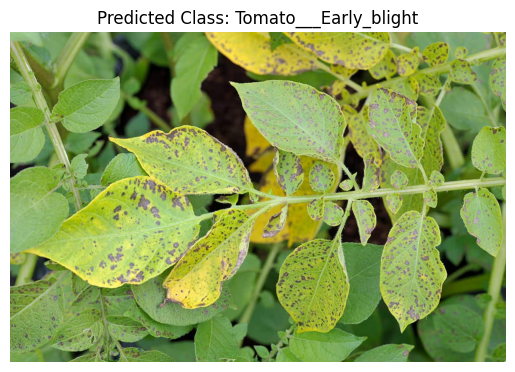

In [ ]:
# Example usage:
test_single_image('/content/Patato.jfif')

1/1 [==============================] - 0s 27ms/step


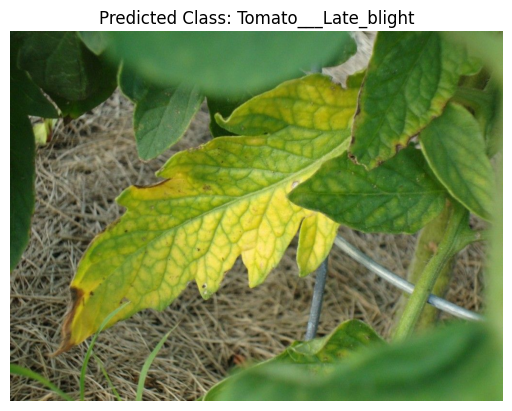

In [ ]:
# Example usage:
test_single_image('/content/Tomato Rot.jpg')

1/1 [==============================] - 0s 66ms/step


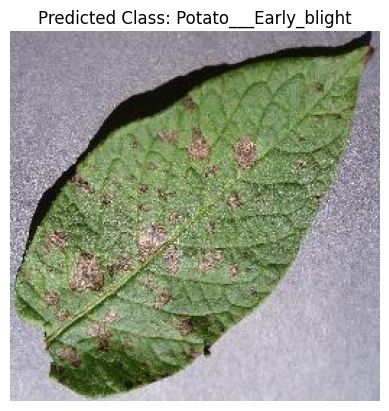

In [ ]:
# Example usage:
test_single_image('/content/gdrive/MyDrive/Capstone Project/DATA/data_split/test/Potato___Early_blight/b3d44557-f696-4fc9-b144-dec4f4ba9452___RS_Early.B 9110.JPG')

1/1 [==============================] - 0s 56ms/step


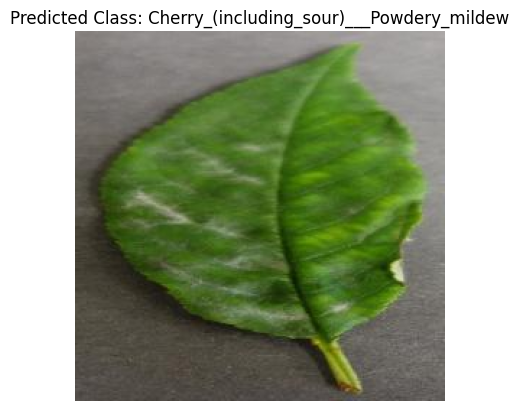

In [ ]:
# Example usage:
test_single_image('/content/gdrive/MyDrive/Capstone Project/DATA/data_split/test/Cherry_(including_sour)___Powdery_mildew/945f0cfe-c6da-4164-92f6-900acad26611___FREC_Pwd.M 4486.JPG')